In [1]:
from Module.MySQL_connector import MySQLConnector
import pandas as pd
import os

In [2]:
# import data from MySQL
sql_connector = MySQLConnector('192.168.31.130', 'bigred', 'bigred', 32010)
sql_connector.connectDB('g3_db')
# print(sql_connector.execute_query('show tables;'))
sql_connector.execute_query('show tables;')
main_table = pd.DataFrame(sql_connector.execute_query("select * from main_aa"))
genres_onehot = pd.DataFrame(sql_connector.execute_query("select * from genres_onehot_aa"))
features_onehot = pd.DataFrame(sql_connector.execute_query("select * from features_onehot_aa"))
tags_onehot = pd.DataFrame(sql_connector.execute_query("select * from tags_onehot_aa"))
id_publisher_aa = pd.DataFrame(sql_connector.execute_query("select * from id_publishers_aa"))
publishers_info_aa = pd.DataFrame(sql_connector.execute_query("select * from publishers_info_aa;"))

Connected to g3_db on 192.168.31.130:32010


In [3]:
# import data from CSV
main_table = pd.read_csv('../../data/AA/main_aa.csv')


In [4]:
copiesold = pd.DataFrame(sql_connector.execute_query("select * from first30days_sales_2A"))

In [5]:
copiesold = copiesold.drop(columns=['timeStamp','releaseDate','days_since_release'])


In [6]:
copiesold

,steamId,sales
0,41050,0.000000e+00
1,41060,5.691300e+04
2,208650,1.796316e+05
3,220200,1.099500e+06
4,223100,5.393900e+04
...,...,...
1179,2881650,1.050977e+06
1180,2903950,4.581000e+03
1181,2933080,9.695800e+04
1182,2969380,2.590000e+03


In [39]:
# 合併時指定 suffixes 參數來處理重複列
merged_table = pd.merge(main_table, genres_onehot, on='steamId', suffixes=('', '_genres'))
merged_table = pd.merge(merged_table, tags_onehot, on='steamId', suffixes=('', '_tags'))
# 再次合併時，處理更多的重複列
merged_table = pd.merge(merged_table, features_onehot, on='steamId', suffixes=('', '_features'))


In [40]:
# 找到所有帶有 '_tags' 或 '_features' 後綴的列名
replicated_columns = [col for col in merged_table.columns if '_tags' in col or '_features' in col]

# 刪除這些列
merged_table.drop(columns=replicated_columns, inplace=True)

In [ ]:
for item in merged_table.columns:
    print(item)

In [41]:
cs_pub = pd.merge(copiesold,id_publisher_aa,on="steamId")
# cs_pub_info = pd.merge(cs_pub, publishers_info_aa, on="steamId")
cs_pub_info = pd.merge(cs_pub, publishers_info_aa, left_on='publisher', right_on="name")
cs_pub_info

,steamId,sales,publisher,name,averageRevenue,medianRevenue,totalRevenue,publishedGames
0,41050,0.000000e+00,Devolver Digital,Devolver Digital,3.097318e+06,555213.0,3.933594e+08,127
1,41060,5.691300e+04,Devolver Digital,Devolver Digital,3.097318e+06,555213.0,3.933594e+08,127
2,208650,1.796316e+05,WB Games,WB Games,2.301824e+07,21042950.0,1.841459e+08,8
3,220200,1.099500e+06,Private Division,Private Division,1.259276e+07,2115005.0,1.385203e+08,11
4,223100,5.393900e+04,Deep Silver,Deep Silver,6.568174e+06,2458665.0,2.298861e+08,35
...,...,...,...,...,...,...,...,...
1240,2881650,1.050977e+06,Landfall,Landfall,8.568731e+06,5725398.0,5.998112e+07,7
1241,2903950,4.581000e+03,"Spike Chunsoft Co., Ltd.","Spike Chunsoft Co., Ltd.",1.565075e+06,425891.5,7.825373e+07,50
1242,2933080,9.695800e+04,505 Games,505 Games,3.749863e+06,708029.0,1.837433e+08,49
1243,2969380,2.590000e+03,"Spike Chunsoft Co., Ltd.","Spike Chunsoft Co., Ltd.",1.565075e+06,425891.5,7.825373e+07,50


In [42]:
cs_pub_info=cs_pub_info.dropna()

In [11]:
cs_pub_info

,steamId,sales,publisher,name,averageRevenue,medianRevenue,totalRevenue,publishedGames
0,41050,0.000000e+00,Devolver Digital,Devolver Digital,3.097318e+06,555213.0,3.933594e+08,127
1,41060,5.691300e+04,Devolver Digital,Devolver Digital,3.097318e+06,555213.0,3.933594e+08,127
2,208650,1.796316e+05,WB Games,WB Games,2.301824e+07,21042950.0,1.841459e+08,8
3,220200,1.099500e+06,Private Division,Private Division,1.259276e+07,2115005.0,1.385203e+08,11
4,223100,5.393900e+04,Deep Silver,Deep Silver,6.568174e+06,2458665.0,2.298861e+08,35
...,...,...,...,...,...,...,...,...
1240,2881650,1.050977e+06,Landfall,Landfall,8.568731e+06,5725398.0,5.998112e+07,7
1241,2903950,4.581000e+03,"Spike Chunsoft Co., Ltd.","Spike Chunsoft Co., Ltd.",1.565075e+06,425891.5,7.825373e+07,50
1242,2933080,9.695800e+04,505 Games,505 Games,3.749863e+06,708029.0,1.837433e+08,49
1243,2969380,2.590000e+03,"Spike Chunsoft Co., Ltd.","Spike Chunsoft Co., Ltd.",1.565075e+06,425891.5,7.825373e+07,50


In [43]:

full_table = pd.merge(cs_pub_info, merged_table, on="steamId",suffixes=('', '_pub'))
# full_table = pd.merge(merged_table, copiesold, on="steamId")


In [58]:
for item in full_table:
    print(item)

steamId
sales
publisher
name
averageRevenue
medianRevenue
totalRevenue
publishedGames
name_pub
price
reviews
reviewsSteam
followers
avgPlaytime
reviewScore
releaseDate
firstReleaseDate
earlyAccess
copiesSold
revenue
totalRevenue_pub
players
owners
wishlists
Action
Adventure
Casual
Early Access
Indie
Massively Multiplayer
RPG
Racing
Simulation
Sports
Strategy
1980s
1990's
2.5D
2D
2D Fighter
2D Platformer
360 Video
3D
3D Fighter
3D Platformer
3D Vision
4 Player Local
4X
6DOF
ATV
Abstract
Action RPG
Action RTS
Action Roguelike
Action-Adventure
Addictive
Agriculture
Aliens
Alternate History
Ambient
America
Animation & Modeling
Anime
Arcade
Archery
Arena Shooter
Artificial Intelligence
Assassin
Asymmetric VR
Asynchronous Multiplayer
Atmospheric
Auto Battler
Automation
Automobile Sim
BMX
Base Building
Baseball
Based On A Novel
Basketball
Battle Royale
Beat 'em up
Beautiful
Benchmark
Bikes
Birds
Blood
Board Game
Boomer Shooter
Boss Rush
Bowling
Boxing
Building
Bullet Hell
Bullet Time
CRPG
Cap

In [44]:
columns_to_drop = ['steamId','totalRevenue_pub','publisher','name_pub','name','reviews','reviewsSteam','followers','avgPlaytime','reviewScore','releaseDate','firstReleaseDate','copiesSold','revenue','totalRevenue','players','owners','wishlists']
full_table=full_table.drop(columns=columns_to_drop)

In [45]:
full_table[['publishedGames','medianRevenue','averageRevenue']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1244 entries, 0 to 1243
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   publishedGames  1244 non-null   int64  
 1   medianRevenue   1244 non-null   float64
 2   averageRevenue  1244 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 29.3 KB


In [46]:
full_table = full_table.dropna()

In [78]:
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 53.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 43.5 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [48]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# 初始化 MinMaxScaler
scaler = MinMaxScaler()


# 選擇要正規化的欄位
columns_to_scale = ["price", "publishedGames", "medianRevenue", "averageRevenue"]

# 對指定欄位進行 Min-Max 轉換
full_table[columns_to_scale] = scaler.fit_transform(full_table[columns_to_scale])
full_table['sales'] = np.log1p(full_table['sales'])
# full_table 中的這些欄位現在已經進行 Min-Max 正規化
print(full_table.head())


       sales  averageRevenue  medianRevenue  publishedGames     price  \
0   0.000000        0.011630       0.002322        0.696133  0.074884   
1  10.949297        0.011630       0.002322        0.696133  0.074884   
2  12.098669        0.100861       0.093901        0.038674  0.249906   
3  13.910367        0.054163       0.009294        0.055249  0.499937   
4  10.895628        0.027177       0.010831        0.187845  0.249906   

   earlyAccess  Action  Adventure  Casual  Early Access  ...  Steam Cloud  \
0        False       1          0       0             0  ...            0   
1        False       1          0       0             0  ...            0   
2        False       1          1       0             0  ...            1   
3        False       0          0       0             0  ...            1   
4        False       1          1       0             0  ...            0   

   Steam Leaderboards  Steam Trading Cards  Steam Turn Notifications  \
0                   0     

In [49]:
min_values = full_table.min()
max_values = full_table.max()

# 顯示結果
value_ranges = pd.DataFrame({'Min': min_values, 'Max': max_values})
print(value_ranges)

                            Min        Max
sales                       0.0  16.540004
averageRevenue              0.0        1.0
medianRevenue               0.0        1.0
publishedGames              0.0        1.0
price                       0.0        1.0
...                         ...        ...
SteamVR Collectibles          0          1
Tracked Controller Support    0          1
VR Only                       0          1
VR Supported                  0          1
Valve Anti-Cheat enabled      0          1

[466 rows x 2 columns]


In [18]:
corr_df = full_table[["averageRevenue","medianRevenue","publishedGames","price","sales"]]

In [18]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 2.9 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


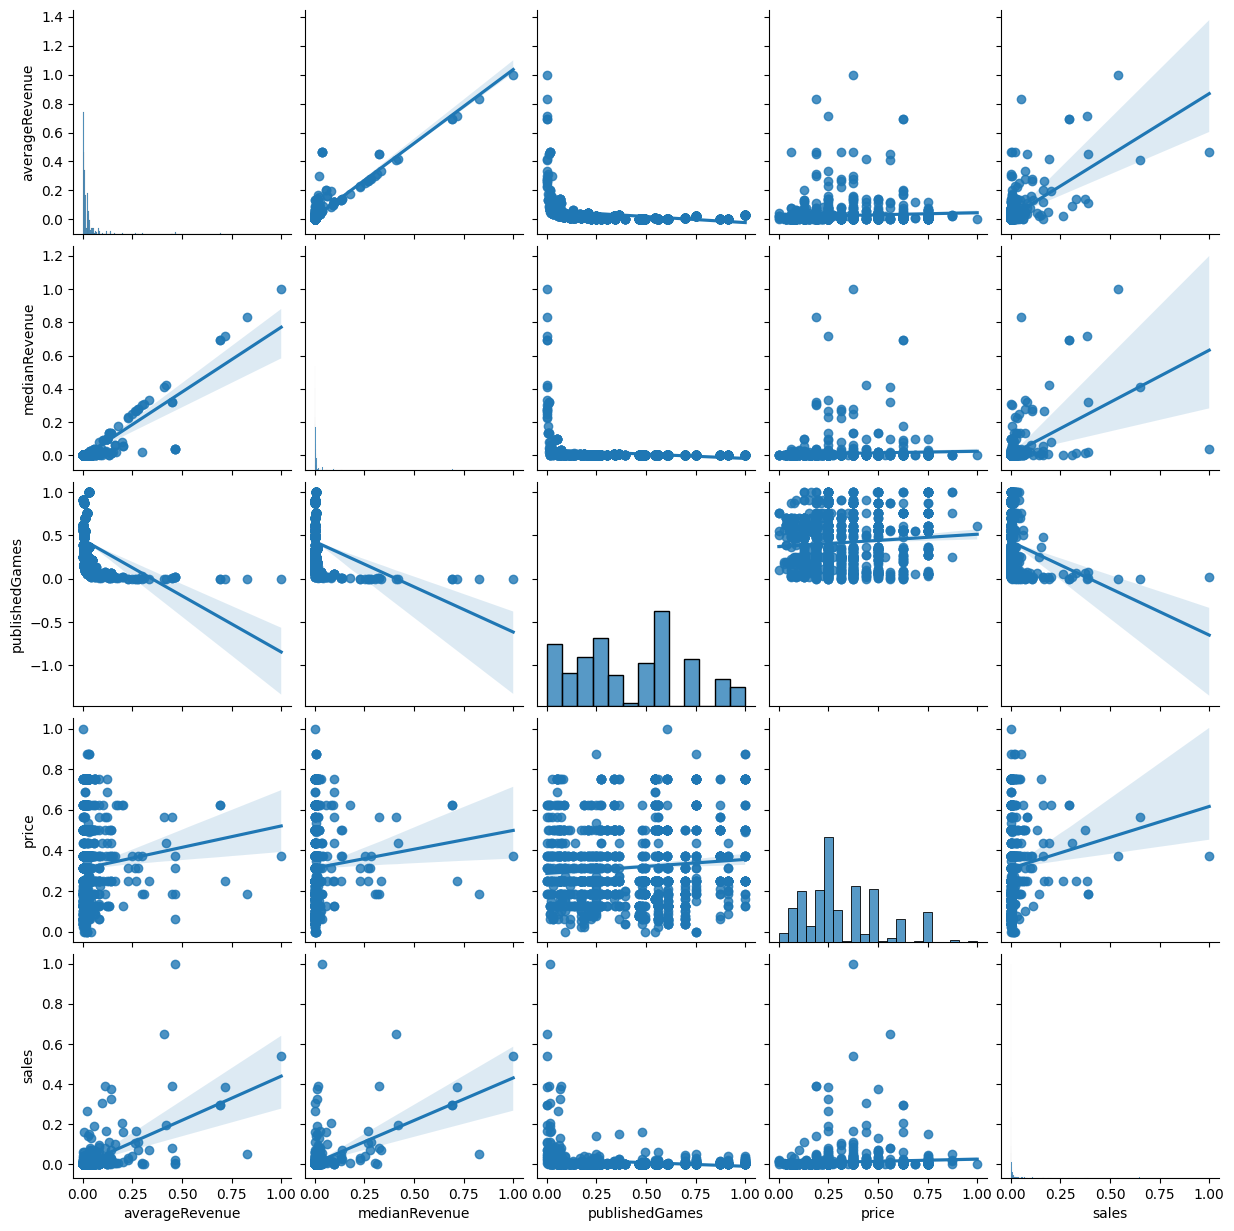

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# 假設 corr_df 是你的數據框
sns.pairplot(corr_df, kind="reg")  # kind="reg" 會添加回歸線

# 顯示圖表
plt.show()

<Axes: >

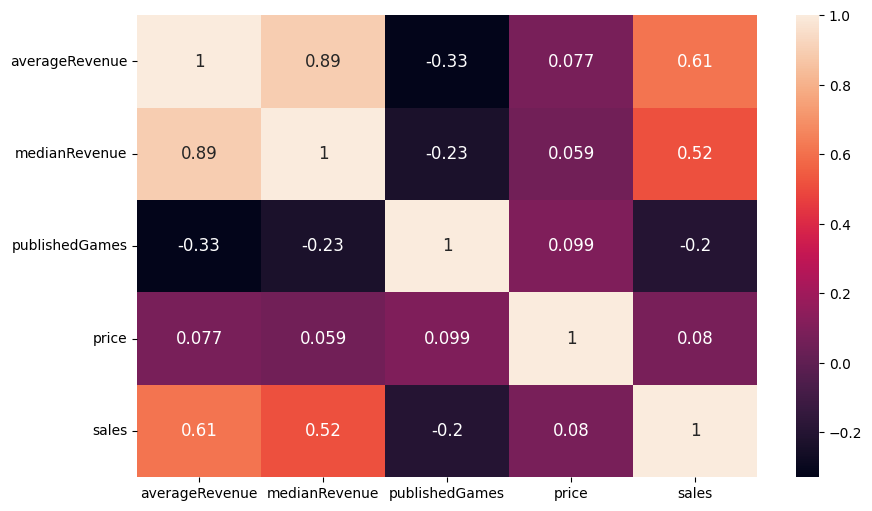

In [20]:
corrmat = corr_df.corr()
fig, ax = plt.subplots(figsize = (10, 6))
sns.heatmap(corrmat, annot = True, annot_kws={'size': 12})

In [94]:
no_one_hot = full_table.iloc[:,:17].drop(columns=["price","medianRevenue"]).drop(columns=["earlyAccess","Early Access","Indie"])
no_one_hot

,sales,averageRevenue,publishedGames,Action,Adventure,Casual,Massively Multiplayer,RPG,Racing,Simulation,Sports,Strategy
0,0.000000,0.011630,0.696133,1,0,0,0,0,0,0,0,0
1,10.949297,0.011630,0.696133,1,0,0,0,0,0,0,0,0
2,12.098669,0.100861,0.038674,1,1,0,0,0,0,0,0,0
3,13.910367,0.054163,0.055249,0,0,0,0,0,0,1,0,0
4,10.895628,0.027177,0.187845,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1239,13.865232,0.036138,0.033149,1,1,0,0,0,0,0,0,0
1240,8.429891,0.004767,0.270718,1,1,0,0,0,0,0,0,0
1241,11.482043,0.014553,0.265193,1,0,0,0,0,0,0,0,0
1242,7.859799,0.004767,0.270718,1,1,0,0,0,0,0,0,0


In [99]:
X = no_one_hot.drop(columns="sales").values
Y = no_one_hot['sales'].values

In [113]:
X_full = full_table.drop(columns="sales").values
Y_full = full_table['sales'].values

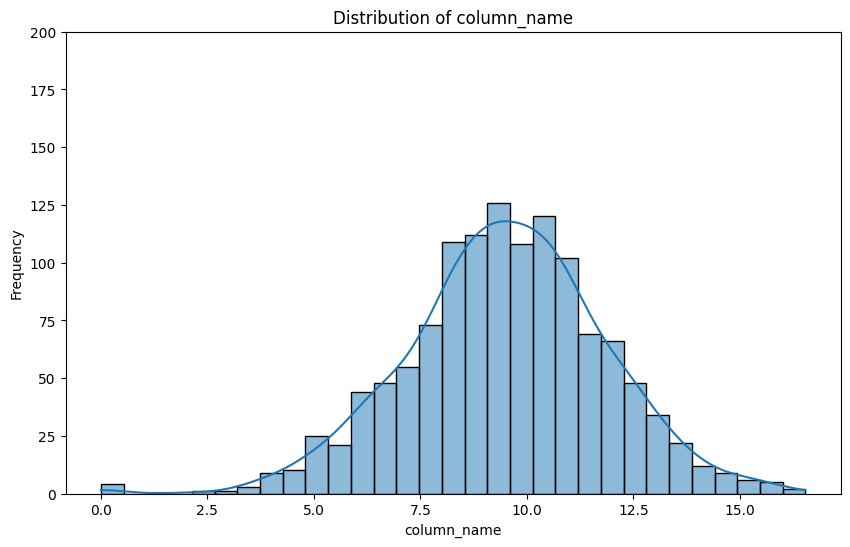

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

# 假設你要繪製 df['column_name'] 的分布
plt.figure(figsize=(10, 6))
sns.histplot(Y, kde=True)  # kde=True 可以添加密度估計曲線
plt.title('Distribution of column_name')
plt.xlabel('column_name')
plt.ylabel('Frequency')
plt.ylim(0, 200)
plt.show()


In [27]:
from sklearn.decomposition import PCA

# 1. 應用 PCA
pca = PCA(n_components=0.95)  # 保留 95% 的變異性
X_pca = pca.fit_transform(X)

In [114]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 25)
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, Y_full, test_size = 0.3, random_state = 25)
# X_pca = pca.fit_transform(X)

In [101]:
print(f"Shape of X_train:{X_train.shape}")
print(f"Shape of X_test:{X_test.shape}")
print(f"Shape of y_train:{y_train.shape}")
print(f"Shape of y_test{y_test.shape}")

Shape of X_train:(870, 11)
Shape of X_test:(374, 11)
Shape of y_train:(870,)
Shape of y_test(374,)


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.metrics import r2_score

In [88]:

lasso = Lasso(alpha = 0.5) # , positive=True
lasso.fit(X_train_1,y_train_1)

y_pred_lasso_train = lasso.predict(X_train_1)
r2_score_lasso_train = lasso.score(X_train_1, y_train_1)

y_pred_lasso_test = lasso.predict(X_test_1)
r2_score_lasso_test = lasso.score(X_test_1, y_test_1)

rmse_lasso_train = (np.sqrt(mean_squared_error(y_train_1, y_pred_lasso_train)))
rmse_lasso_test = (np.sqrt(mean_squared_error(y_test_1, y_pred_lasso_test)))

print("coef：")
for i, j in zip(full_table.columns, lasso.coef_):
    print(i, j)

coef：
sales 0.0
averageRevenue -0.0
medianRevenue 0.0
publishedGames 0.0
price -0.0
earlyAccess 0.0


In [89]:
print("R2_score (train): ",r2_score_lasso_train)
print("R2_score (test):", r2_score_lasso_test)
print("train_RMSE: ", rmse_lasso_train)
print("test_RMSE: ", rmse_lasso_test)

R2_score (train):  0.0
R2_score (test): -0.0020546876507587797
train_RMSE:  2.3266997357623826
test_RMSE:  2.31541695171994


In [31]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

# 創建多項式特徵並應用 Lasso 回歸
degree = 2  # 指定多項式的次數
lasso_poly = make_pipeline(PolynomialFeatures(degree), Lasso(alpha=0.1))

# 訓練模型
lasso_poly.fit(X_train, y_train)

# 預測
y_pred_train = lasso_poly.predict(X_train)
y_pred_test = lasso_poly.predict(X_test)

# 計算 R² 分數
r2_score_lasso_train = r2_score(y_train, y_pred_train)
r2_score_lasso_test = r2_score(y_test, y_pred_test)

# 計算 RMSE
rmse_lasso_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_lasso_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

# 打印結果
print("R² score (train):", r2_score_lasso_train)
print("R² score (test):", r2_score_lasso_test)
print("Train RMSE:", rmse_lasso_train)
print("Test RMSE:", rmse_lasso_test)


R² score (train): 0.0
R² score (test): -0.004248119551302443
Train RMSE: 0.055388731112005464
Test RMSE: 0.034532975791111


In [102]:
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree = 2)
X_poly = poly_reg.fit_transform(X_train)
poly_reg.fit(X_poly, y_train)
regressor_poly2 = LinearRegression()
regressor_poly2.fit(X_poly, y_train)

y_pred_poly2_train = regressor_poly2.predict(poly_reg.fit_transform(X_train))
r2_score_poly2_train = r2_score(y_train, y_pred_poly2_train)

y_pred_poly2_test = regressor_poly2.predict(poly_reg.fit_transform(X_test))
r2_score_poly2_test = r2_score(y_test, y_pred_poly2_test)

rmse_train = (np.sqrt(mean_squared_error(y_train, y_pred_poly2_train)))
rmse_test = (np.sqrt(mean_squared_error(y_test, y_pred_poly2_test)))

print('R2_score (train): ', r2_score_poly2_train)
print('R2_score (test): ', r2_score_poly2_test)
print("RMSE: ", rmse_train)
print("RMSE: ", rmse_test)

R2_score (train):  0.36852142496176077
R2_score (test):  0.032565051195785344
RMSE:  1.8489265152600651
RMSE:  2.2750680040879843


In [142]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

def poly_ridge(X_train, X_test, y_train, y_test):
    # 使用 Ridge 進行正則化回歸
    degree = 2  # 減少多項式次數
    ridge_poly = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=0.01))

    # 訓練模型
    ridge_poly.fit(X_train, y_train)

    # 預測
    y_pred_train = ridge_poly.predict(X_train)
    y_pred_test = ridge_poly.predict(X_test)

    # 計算 R² 分數
    r2_score_ridge_train = r2_score(y_train, y_pred_train)
    r2_score_ridge_test = r2_score(y_test, y_pred_test)

    # 計算 RMSE
    rmse_ridge_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_ridge_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

    # 打印結果
    print("R² score (train):", r2_score_ridge_train)
    print("R² score (test):", r2_score_ridge_test)
    print("Train RMSE:", rmse_ridge_train)
    print("Test RMSE:", rmse_ridge_test)

poly_ridge(X_train, X_test, y_train, y_test)
poly_ridge(X_train_full, X_test_full, y_train_full, y_test_full)


R² score (train): 0.3659536834797841
R² score (test): 0.12505863783054139
Train RMSE: 1.852681788284249
Test RMSE: 2.163580061304981
R² score (train): 0.9862681206307926
R² score (test): 0.3815388929973348
Train RMSE: 0.27264989220968533
Test RMSE: 1.819029294746391


In [140]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.98)
X_pca = pca.fit_transform(X_full)
# X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_pca, Y_full, test_size = 0.3, random_state = 25)
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, Y_full, test_size = 0.3, random_state = 25)

In [143]:
poly_ridge(X_train_full, X_test_full, y_train_full, y_test_full)

R² score (train): 0.9862681206307926
R² score (test): 0.3815388929973348
Train RMSE: 0.27264989220968533
Test RMSE: 1.819029294746391
